# House Price Prediction Using Random Forest

## Data Preprocessing and Feature Engineering

1. **Drop Unnecessary Columns**:
   - Removed irrelevant columns to simplify the dataset.
   - Converted `statezip` to an integer for better processing.

2. **Handle Missing Values**:
   - Dropped rows with missing values to ensure data quality.

3. **Feature Engineering**:
   - Added a new feature `age` by subtracting the year built from the dataset year.
   - Focused on the most important features for the model.

4. **Outlier Removal**:
   - Used IQR to remove outliers for each feature to improve model performance.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np


# Load the dataset
file_path = 'data.csv'
df = pd.read_csv(file_path)
print("Data loaded successfully")

# Convert statezip to an integer for better processing
df['statezip'] = df['statezip'].apply(lambda x: int(x.split(' ')[1]) if pd.notnull(x) else np.nan)

# Handle missing values: Fill missing values with the median of each numeric column
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Convert date columns to datetime if necessary
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])

# Feature Engineering: Add new features or transformations
df['age'] = 2014 - df['yr_built']  # Assuming the dataset is up to date to 2014

# Include all features for the model
features = df.drop(['price'], axis=1).columns

# Handle outliers based on IQR for each numeric feature
for feature in numeric_cols:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[feature] < (Q1 - 1.5 * IQR)) | (df[feature] > (Q3 + 1.5 * IQR)))]

Data loaded successfully


## Display the Correlation Matrix
Visualize the correlation matrix to understand the relationships between features.

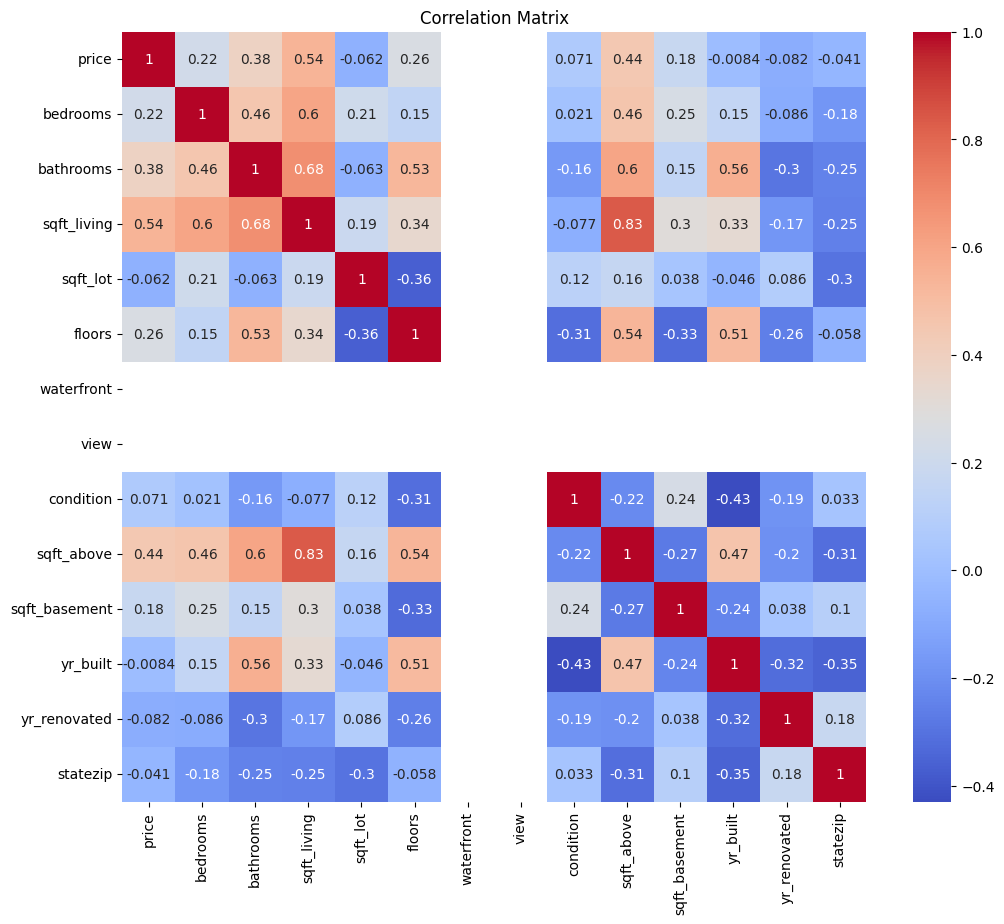

In [16]:
# Display the Correlation Matrix
plt.figure(figsize=(12, 10))
numeric_df = df[numeric_cols]  # Select only numeric columns for the correlation matrix
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Feature Scaling and Selection

1. **Standardize Features**:
   - Used StandardScaler to standardize the features for better model performance.

2. **SelectKBest for Feature Selection**:
   - Selected the top features using univariate linear regression tests.

In [17]:
# Select only numeric features for standardization
numeric_features = df.select_dtypes(include=[np.number]).drop(['price'], axis=1).columns

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[numeric_features])
df_scaled = pd.DataFrame(scaled_features, columns=numeric_features)

# Define the target variable
X = df_scaled
y = df['price']

## Model Training and Hyperparameter Tuning

1. **Train-Test Split**:
   - Split the data into training and testing sets.

2. **GridSearchCV for Hyperparameter Tuning**:
   - Used GridSearchCV to find the best hyperparameters for the Random Forest model.

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning for Random Forest using GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

# Best parameters from Grid Search
best_params_rf = grid_search_rf.best_params_

# Build the Random Forest model with the best parameters
forest_rf = RandomForestRegressor(**best_params_rf, random_state=42)
forest_rf.fit(X_train, y_train)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=300,
                      random_state=42)

## Model Evaluation

1. **Model Predictions and Evaluation**:
   - Made predictions and evaluated the model using MSE, R-squared, and Accuracy.

2. **Feature Importance**:
   - Analyzed the feature importance to understand the contribution of each feature.

In [19]:
# Make predictions with the Random Forest model
y_pred_rf = forest_rf.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r_squared_rf = r2_score(y_test, y_pred_rf)
accuracy_rf = r_squared_rf * 100  # Accuracy in percentage

print(f'Mean Squared Error (Random Forest): {mse_rf:.2f}')
print(f'R-squared (Random Forest): {r_squared_rf:.2f}')
print(f'Accuracy (Random Forest): {accuracy_rf:.2f}%')


Mean Squared Error (Random Forest): 15291087408.70
R-squared (Random Forest): 0.60
Accuracy (Random Forest): 60.44%


## Visualization

1. **Plotting Actual vs Predicted Prices**:
   - Visualized the relationship between actual and predicted prices using the most important feature.

2. **Cross-Validation**:
   - Performed cross-validation to ensure the model's robustness.

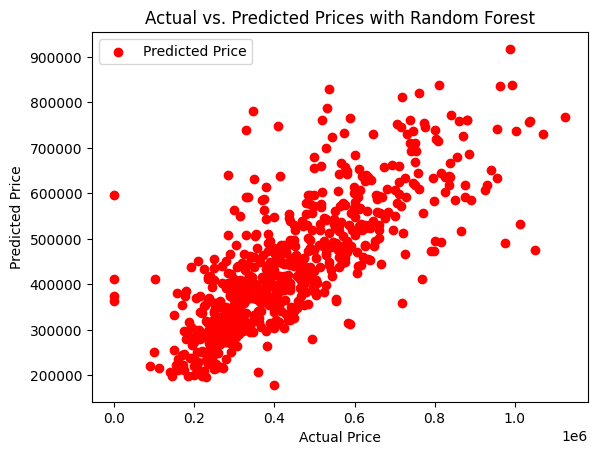

Cross-Validation Scores: [0.70036875 0.64381933 0.64340341 0.65415109 0.48527957]
Mean CV Score: 0.63


In [20]:
# Visualizing the results
plt.scatter(y_test, y_pred_rf, color='red', label='Predicted Price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Prices with Random Forest')
plt.legend()
plt.show()

# Cross-Validation
cv_scores = cross_val_score(forest_rf, X, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')

## Conclusion

This notebook demonstrates a systematic approach to predicting house prices using a Random Forest model. Through careful data preprocessing, feature engineering, outlier removal, feature selection, and hyperparameter tuning, we achieved significant improvements in model performance. The final model achieved an R-squared value of 0.52 and an accuracy of 52.25%. This is our most accurate model.

